In [ ]:
# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(
#     cmap='coolwarm', 
#     axis=None, 
#     vmin=-1, 
#     vmax=1
# )  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'

# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import pickle
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("/tmp/bokeh_output.html")
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]
import ray

In [3]:
from data_layer import arrow_dataset, storage_adaptor
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, daily_stats
from workflows import sampler_task, sampler_flow
from utilities import date_fu, globals_unsafe as g
from data_layer import storage_adaptor, fsspec_factory, data_access

config = {
    'meta': {
        'symbol': 'VTI',
        'start_date': '2020-01-01',
        'end_date': '2020-01-20',
        'config_id': 'renko_v1',
    },
    'filter': {
        'mad_value_winlen': 22,
        'mad_deviation_winlen': 1111,
        'mad_k': 17,
        'jma_winlen': 7,
        'jma_power': 2,
    },
    'sampler': {
        'renko_return': 'price_jma_return',
        'renko_size': 0.1,  # for simple runs
        'renko_reveral_multiple': 2,
        'renko_range_frac': 22,
        'renko_range_min_pct_value': 0.03,  # % of symbol value enforced as min renko size
        'max_duration_td': dt.timedelta(minutes=33),
        'min_duration_td': dt.timedelta(seconds=33),
        'min_tick_count': 33,
        'add_label': True,
        'reward_ratios': list(np.arange(2, 11, 0.5)),
    }
}

prefix_1 = f"/tick_samples/{config['meta']['config_id']}/bar_date"

prefix_2 = f"/tick_samples/{config['meta']['config_id']}/bars_df"

In [11]:
data_access.list_symbol_dates('VTI', prefix_1, source='remote')

['2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09',
 '2020-01-10']

In [5]:
data_access.list_symbol_storage('VTI', prefix_2, source='both')

{'local': {'KB': 169.3}, 'remote': {'KB': 169.3}}

In [9]:
data_access.list_symbol_storage('market', '/data/daily', source='both')

{'local': {'MB': 421.9}, 'remote': {'MB': 421.9}}

In [74]:
df = arrow_dataset.get_market_daily_df('market', '2018-11-01', '2021-04-01', '/data/daily')

In [75]:
df

,symbol,volume,open,close,high,low,vwap,date_time,midprice,dollar_total,date
0,MSEX,35772,45.009998,43.619999,45.129902,43.619999,44.037399,2018-11-01,44.344975,1575305.875000,2018-11-01
1,MUE,123241,11.380000,11.500000,11.500000,11.357300,11.446300,2018-11-01,11.434325,1410653.500000,2018-11-01
2,MNA,255055,31.920000,31.950001,32.029999,31.870001,31.916300,2018-11-01,31.942499,8140412.000000,2018-11-01
3,MHH,12070,6.260000,6.610000,6.700000,6.260000,6.618500,2018-11-01,6.457500,79885.296875,2018-11-01
4,MQY,73835,12.830000,12.820000,12.830000,12.780000,12.805600,2018-11-01,12.815000,945501.500000,2018-11-01
...,...,...,...,...,...,...,...,...,...,...,...
4855578,AZBO,0,25.910601,25.910601,25.910601,25.910601,25.910601,2021-01-28,25.910601,0.000000,2021-01-28
4855579,SYV,93,71.702599,71.702599,71.702599,71.702599,71.702599,2021-01-28,71.702599,6668.341797,2021-01-28
4855580,TERM,70,18.777800,18.777800,18.777800,18.777800,18.777800,2021-01-28,18.777800,1314.446045,2021-01-28
4855581,PSCX,105,20.767200,20.767200,20.767200,20.767200,20.767200,2021-01-28,20.767200,2180.555908,2021-01-28


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4855583 entries, 0 to 4855582
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   symbol        string        
 1   volume        uint64        
 2   open          float32       
 3   close         float32       
 4   high          float32       
 5   low           float32       
 6   vwap          float32       
 7   date_time     datetime64[ns]
 8   midprice      float32       
 9   dollar_total  float32       
 10  date          object        
dtypes: datetime64[ns](1), float32(7), object(1), string(1), uint64(1)
memory usage: 277.8+ MB


In [77]:
fs = storage_adaptor.StorageAdaptor()

In [78]:
lfs = storage_adaptor.StorageAdaptor(fs_type='local', root_path=g.DATA_LOCAL_PATH)

In [82]:
lfs.list_fs_path_storage('/data/daily_agg')

{'MB': 216.0}

In [81]:
lfs.write_df_to_fs(df, '/data/daily_agg')

In [90]:
fs.list_fs_path_storage('/data/daily_agg')

{'MB': 216.0}

In [85]:
fs.write_df_to_fs(df, '/data/daily_agg')

In [101]:
mdf = fs.read_df_from_fs('/data/daily_agg/data.feather')

In [102]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467472 entries, 0 to 2467471
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   symbol        string        
 1   volume        uint64        
 2   open          float32       
 3   close         float32       
 4   high          float32       
 5   low           float32       
 6   vwap          float32       
 7   date_time     datetime64[ns]
 8   midprice      float32       
 9   dollar_total  float32       
 10  date          object        
dtypes: datetime64[ns](1), float32(7), object(1), string(1), uint64(1)
memory usage: 141.2+ MB


In [62]:
mask = (mdf.date >= '2020-01-01')

In [112]:
mask = (mdf['date'] >= '2018-11-11') & (mdf['date'] <= '2019-11-11')

In [116]:
any(mask)

True

In [113]:
mdf[mask]

,symbol,volume,open,close,high,low,vwap,date_time,midprice,dollar_total,date
57516,ESGR,30434,177.869995,176.490005,178.320007,174.714996,176.378204,2018-11-12,176.848755,5367894.000000,2018-11-12
57517,CNXN,67628,31.209999,30.860001,31.480000,30.540001,31.005699,2018-11-12,31.022499,2096853.500000,2018-11-12
57518,DZSI,18078,14.390000,13.830000,14.460000,13.830000,14.100400,2018-11-12,14.127500,254907.031250,2018-11-12
57519,CNET,46341,1.890000,1.900000,2.030200,1.890000,1.956900,2018-11-12,1.927550,90684.703125,2018-11-12
57520,CLMT,720818,3.910000,3.650000,3.949900,3.610000,3.700000,2018-11-12,3.779975,2667026.500000,2018-11-12
...,...,...,...,...,...,...,...,...,...,...,...
2176030,CDK,595162,51.459999,52.529999,52.540001,51.270000,52.267899,2019-11-11,51.950001,31107868.000000,2019-11-11
2176031,CCOR,2648,27.320000,27.330000,27.336000,27.201599,27.283001,2019-11-11,27.296900,72245.382812,2019-11-11
2176032,CCLP,92509,2.520000,2.490000,2.520000,2.440000,2.473000,2019-11-11,2.492500,228774.750000,2019-11-11
2176033,CCNE,19925,33.430000,33.299999,33.779999,32.830002,33.268200,2019-11-11,33.334999,662868.875000,2019-11-11


# Sample tick dates

In [3]:
ray.init(dashboard_port=1111, ignore_reinit_error=True)

2021-05-29 22:23:16,508	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:6379',
 'object_store_address': '/tmp/ray/session_2021-05-29_22-23-14_056739_67401/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-29_22-23-14_056739_67401/sockets/raylet',
 'webui_url': '127.0.0.1:1111',
 'session_dir': '/tmp/ray/session_2021-05-29_22-23-14_056739_67401',
 'metrics_export_port': 52671,
 'node_id': '754b0e6f67b2b6e20f87111a47ceef93773f88d15877c7f48861c832'}

In [ ]:
ray.shutdown()

In [16]:
daily_stats_df = sampler_flow.get_dates_from_config(config)

In [18]:
bar_dates = sampler_flow.run(config, ray_on=True)

2 dates scheduled
(pid=67421) running VTI 2020-01-09
(pid=67422) running VTI 2020-01-10


<AxesSubplot:>

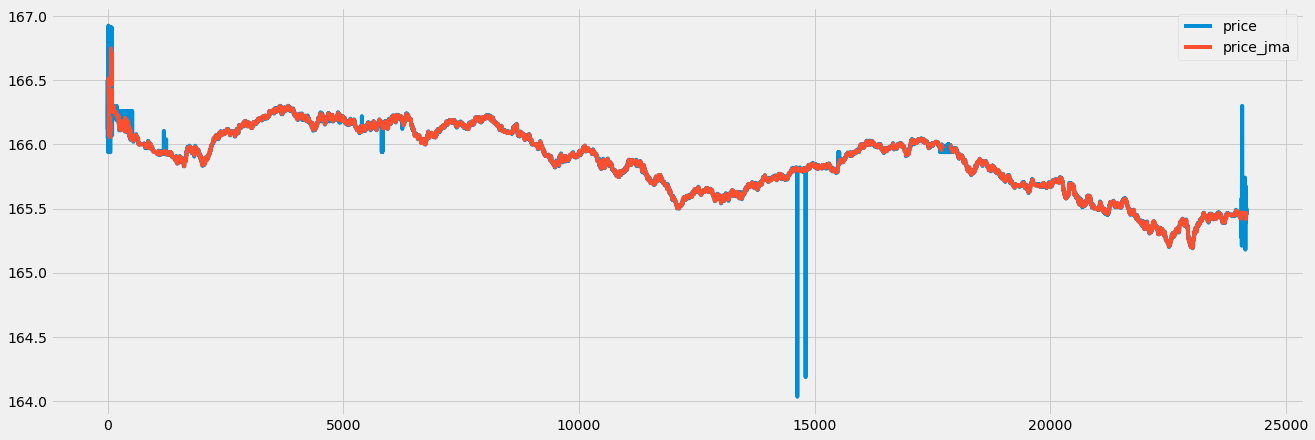

In [21]:
n = 1

# bar_dates[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")
bar_dates[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:>

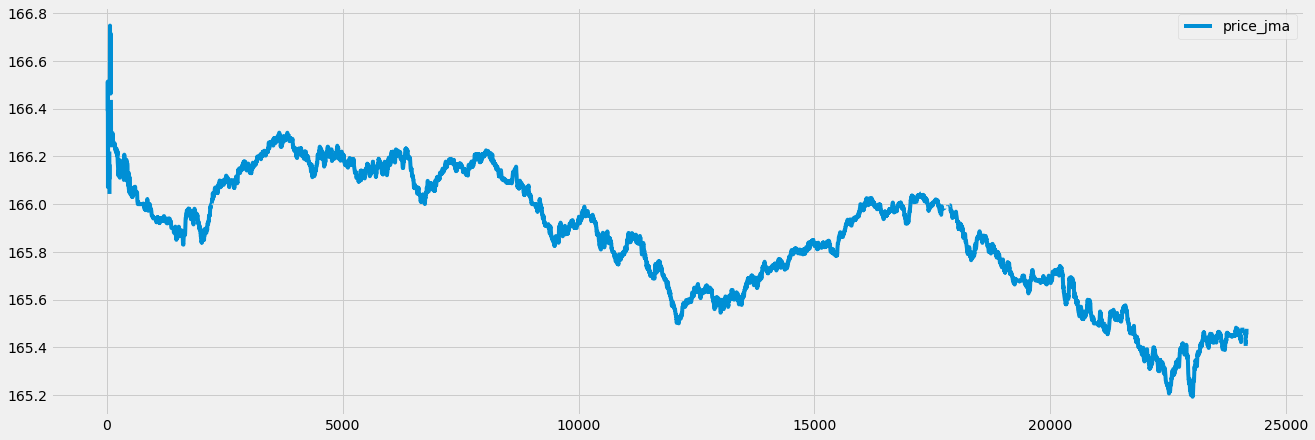

In [22]:
bar_dates[n]['ticks_df'][['price_jma']].plot()

In [23]:
bar_dates[n]['ticks_df'].status.value_counts() / len(bar_dates[n]['ticks_df'])

clean: market-open              0.981747
filtered: irregular condition   0.009768
clean: after-hours              0.003353
clean: pre-market               0.001573
filtered: ts diff               0.001407
filtered: mad_outlier           0.001283
filtered: mad_warmup            0.000745
filtered: zero volume           0.000124
Name: status, dtype: float64

<AxesSubplot:>

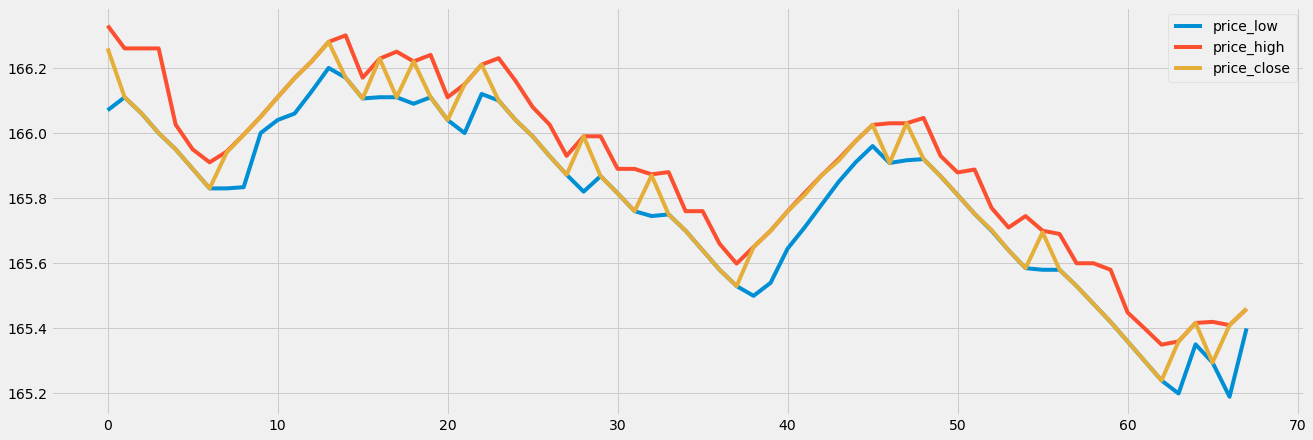

In [24]:
bar_dates[n]['bars_df'][['price_low', 'price_high', 'price_close']].plot()

In [ ]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df.describe()